# February, 13th 2021

**Motivation**: Simple analysis on data. Learn how it is structured, come up with clarification questions.<br>
**Results**:  In this document I focus on Ca sinals.

In [1]:
# HIDE CODE


import re
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.stats import pearsonr
from os.path import join as pjoin
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# HIDE CODE


base_dir = '/home/hadi/Documents/Ca-fMRI'
raw_dir = pjoin(base_dir, 'raw')
processed_dir = pjoin(base_dir, 'processed')
os.makedirs(processed_dir, exist_ok=True)

shared_names = []
for file_name in sorted(os.listdir(raw_dir)):
    meta = file_name.split('_')
    sub = next(filter(lambda x: 'sub' in x, meta))
    ses = next(filter(lambda x: 'ses' in x, meta))
    run = next(filter(lambda x: 'run' in x, meta))
    task = next(filter(lambda x: 'task' in x, meta))
    shared_names.append('_'.join([sub, ses, task, run]))
shared_names = sorted(list(np.unique(shared_names)))

# process and save files
for keyword in tqdm(shared_names):
    selected_files = [f for f in os.listdir(raw_dir) if keyword in f]
    bold_file_name = next(filter(lambda x: 'bold' in x, selected_files))
    
    meta = bold_file_name.split('_')
    sub = next(filter(lambda x: 'sub' in x, meta))
    ses = next(filter(lambda x: 'ses' in x, meta))
    run = next(filter(lambda x: 'run' in x, meta))
    task = next(filter(lambda x: 'task' in x, meta))
    key = '_'.join([sub, ses, run, task])

    # bold
    with open(pjoin(raw_dir, bold_file_name)) as f:
        data = nib.load(f.name).get_fdata()
    
    save_filename = pjoin(processed_dir, key + '_bold.npy')
    np.save(save_filename, data)
    
    # ca
    ca_files = [item for item in selected_files if 'ca' in item]
    ca_data_list = []
    for ca_file_name in ca_files:
        with open(pjoin(raw_dir, ca_file_name)) as f:
            ca_data_list.append(nib.load(f.name).get_fdata())
    
    data = np.concatenate(ca_data_list, axis=-1)
    save_filename = pjoin(processed_dir, key + '_ca.npy')
    np.save(save_filename, data)


## Simple plots (Ca data)

Let's make a few plots to just look at the data.  I will select a few datasets (name in the plot title) and plot time traces in three different time windows.  Also, below this, I will plot the time average of the entire FOV time series.  And I also time average of the absolute value of the traces.

----------------------------------------------------------------------------------------------------


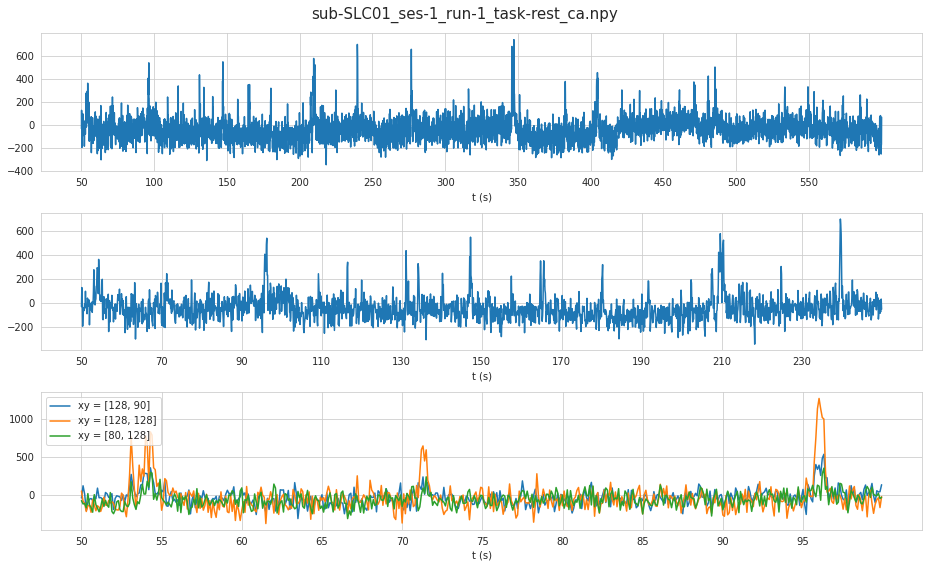

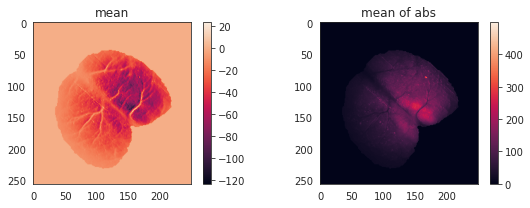

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


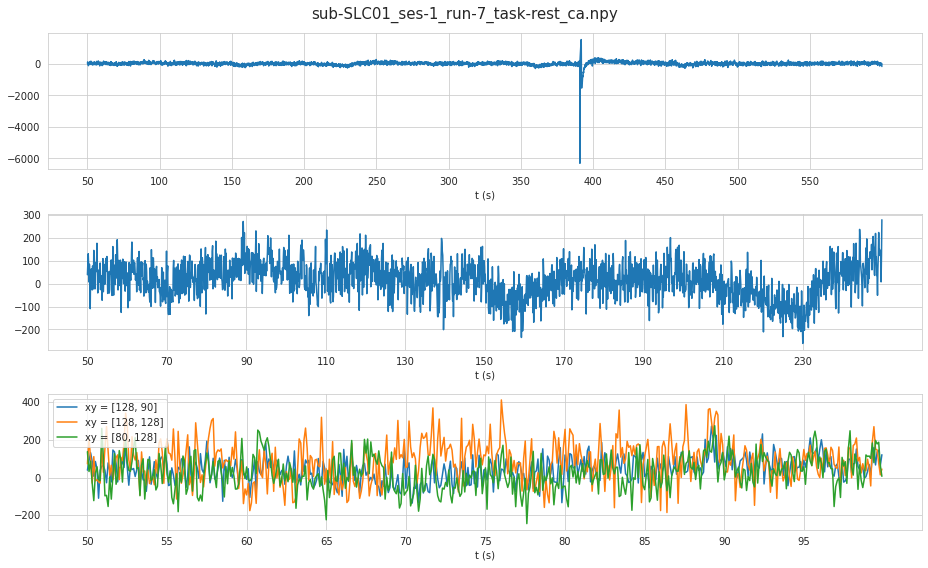

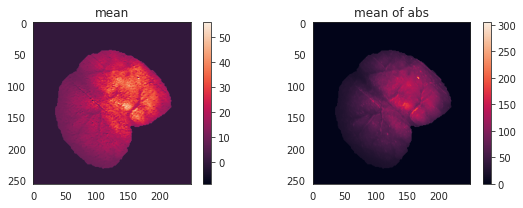

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


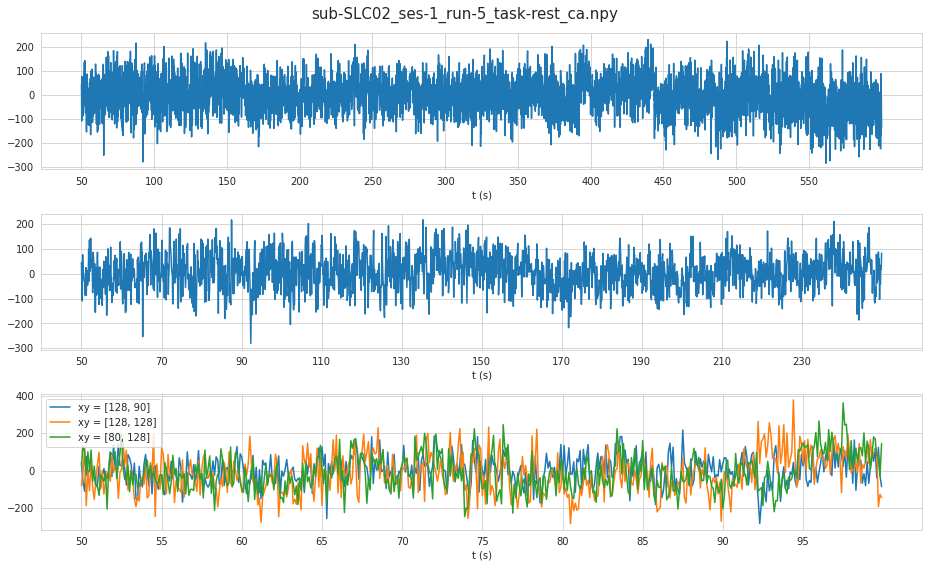

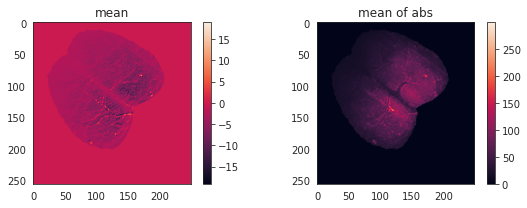

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


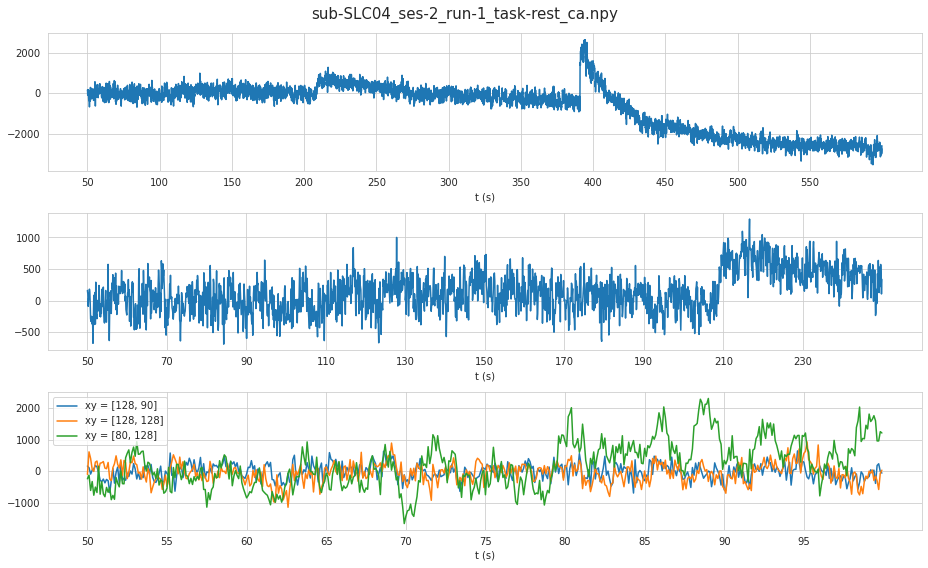

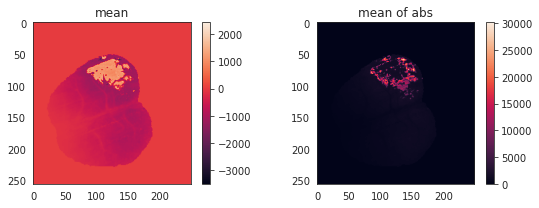

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


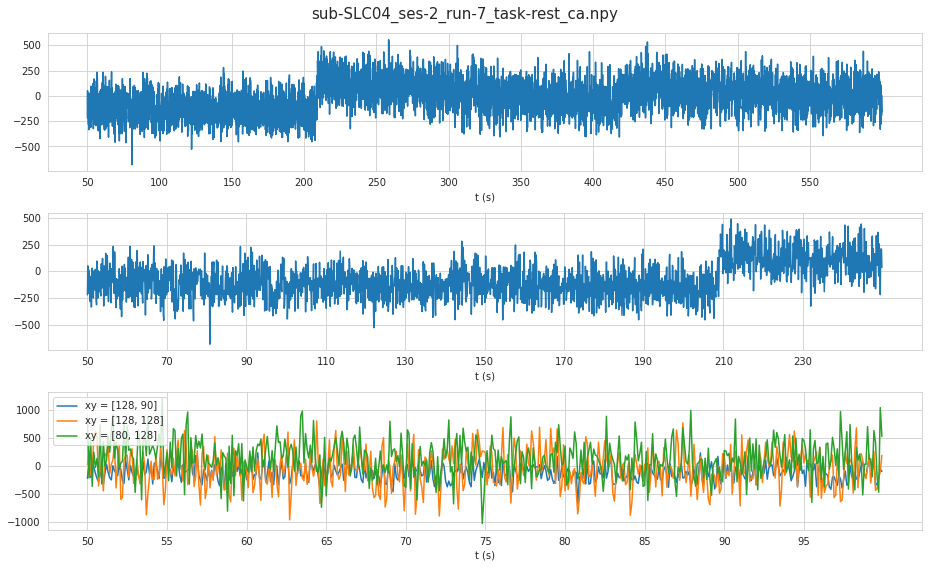

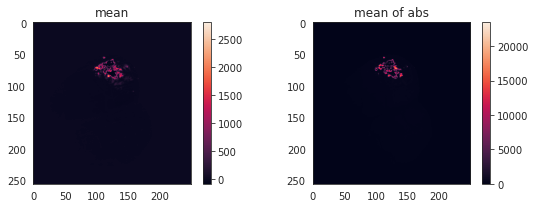

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


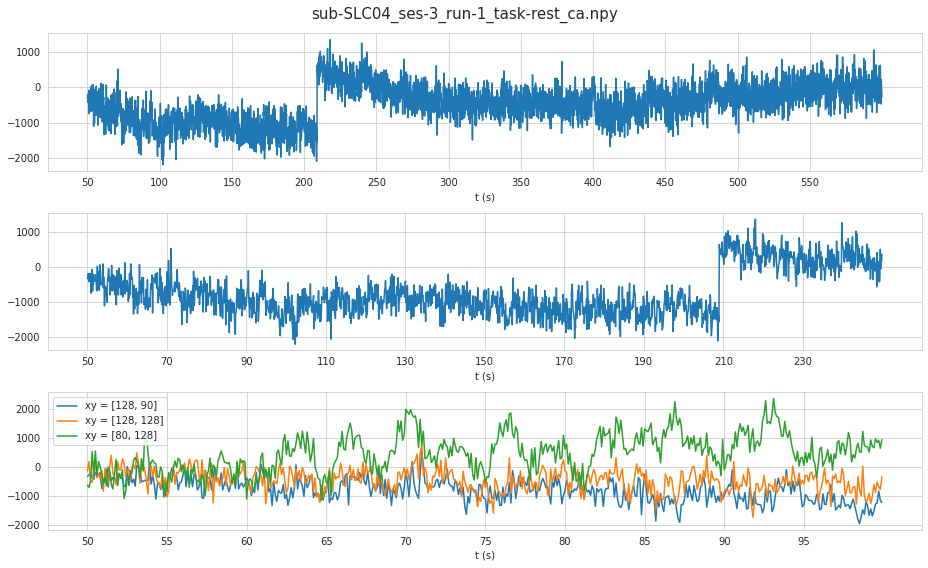

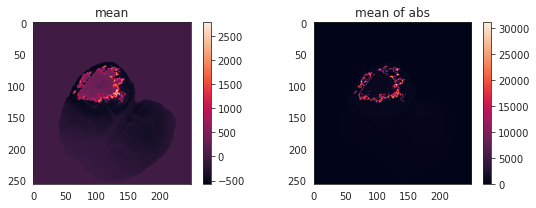

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


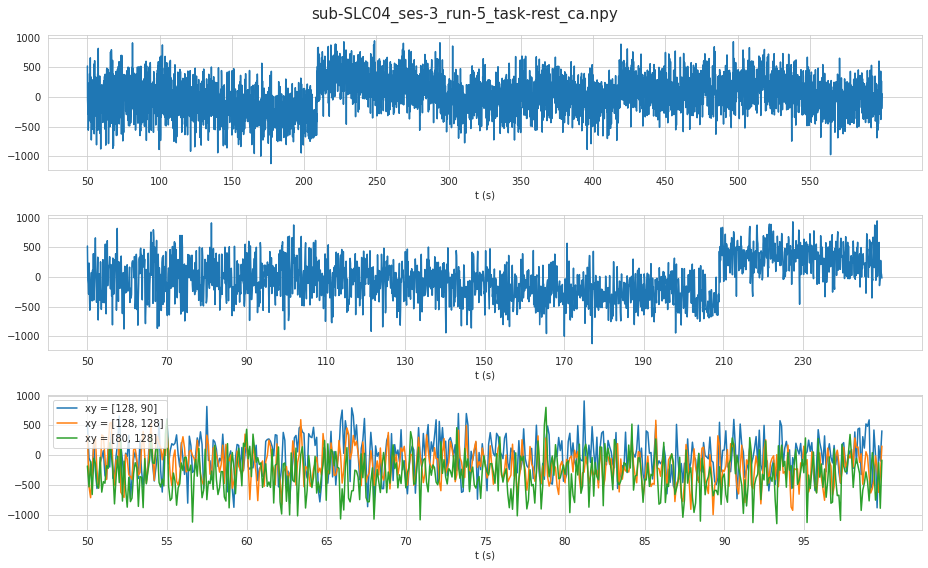

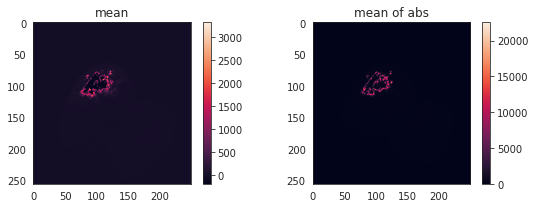

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


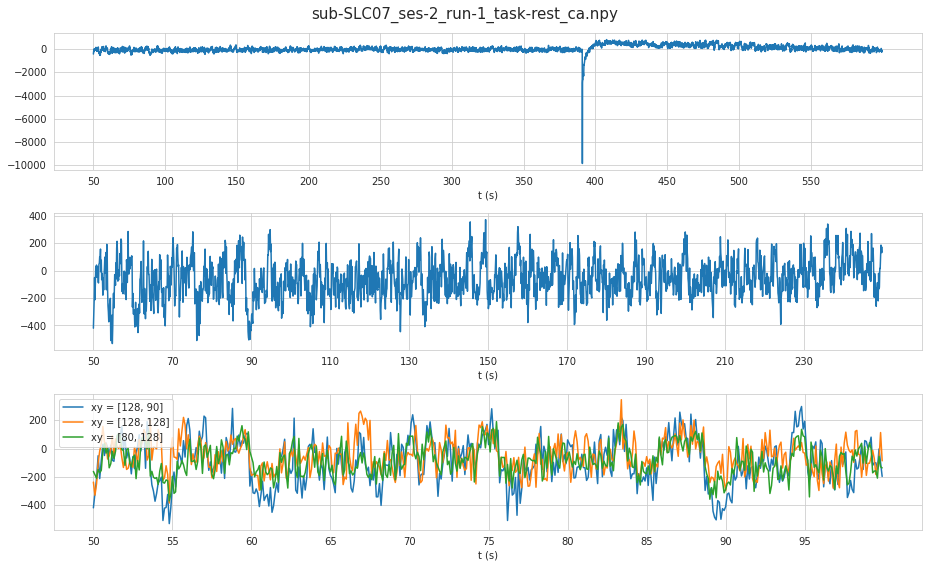

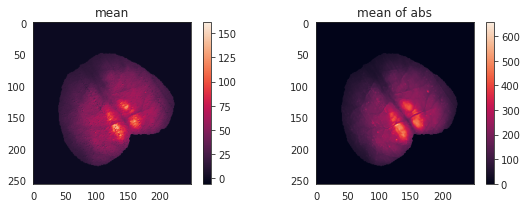

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


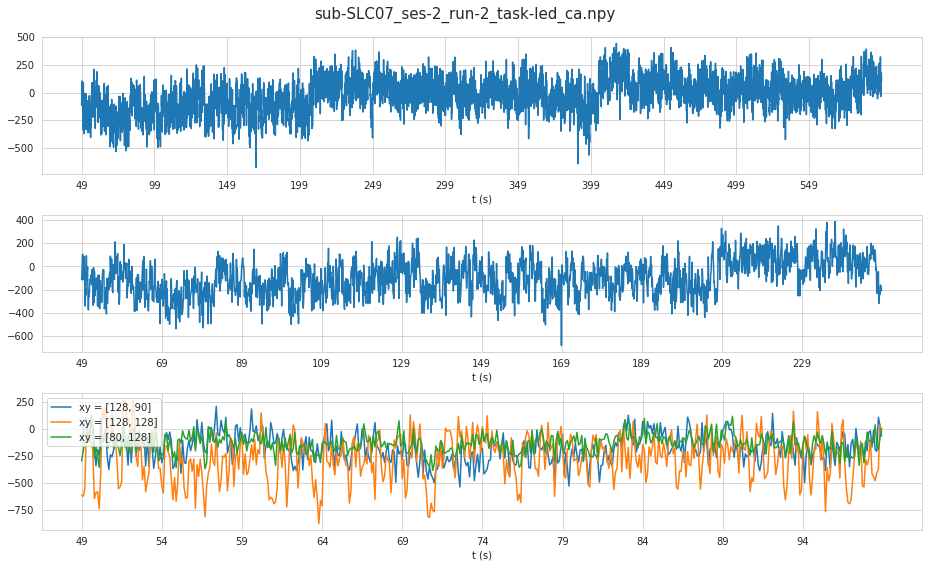

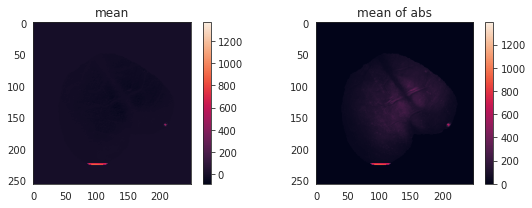

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


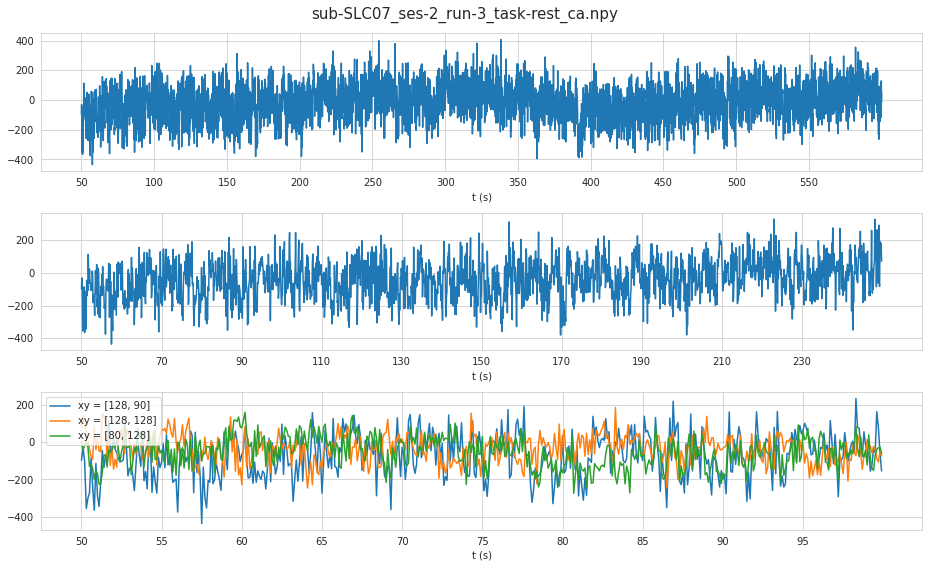

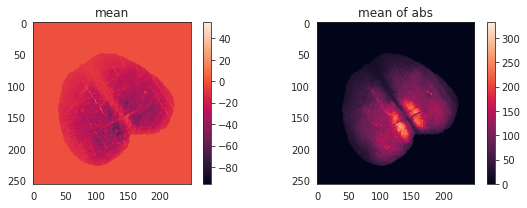

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


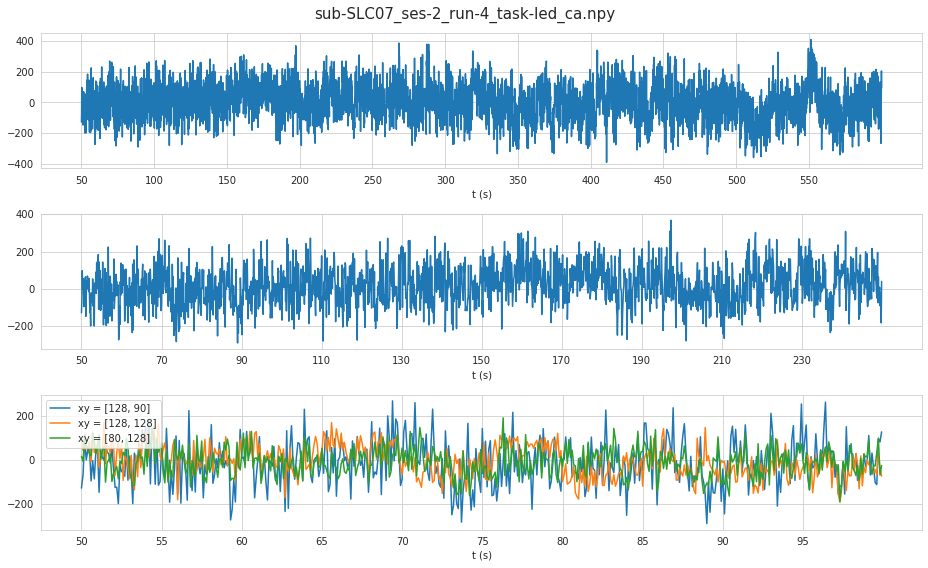

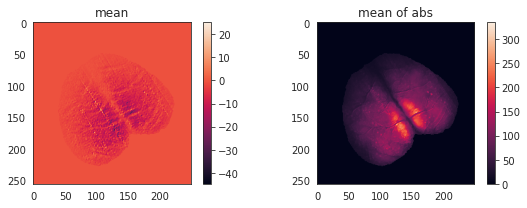

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


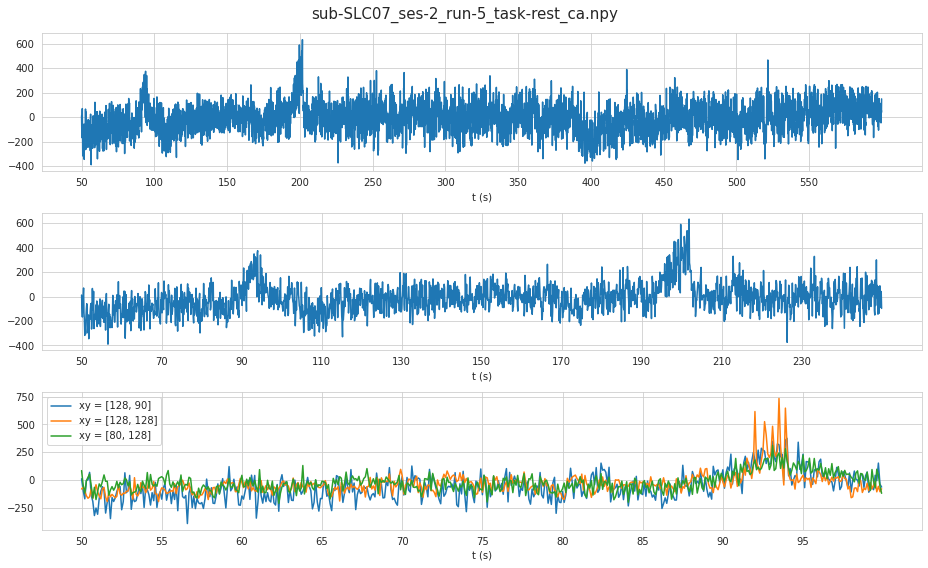

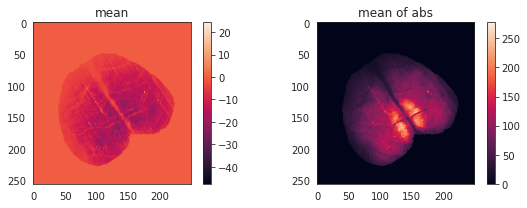

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


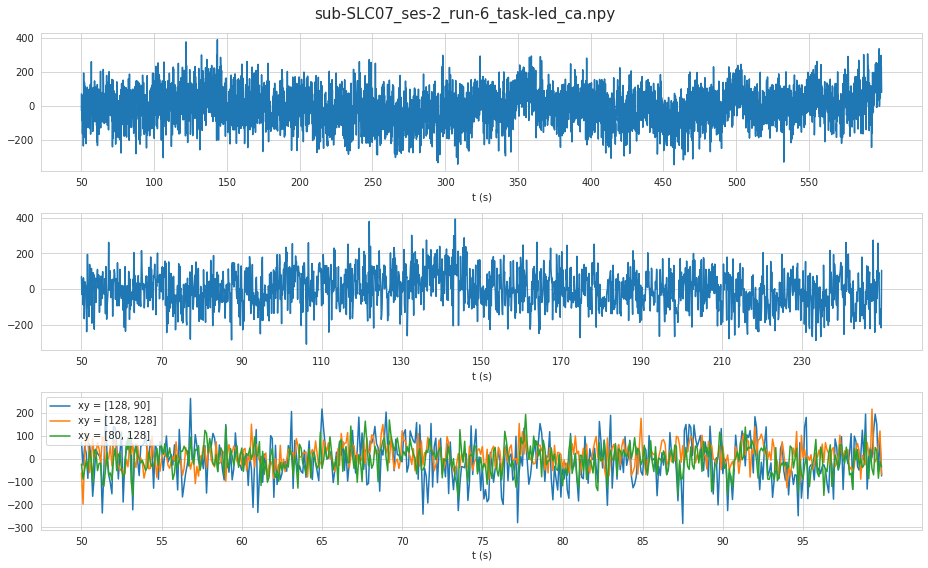

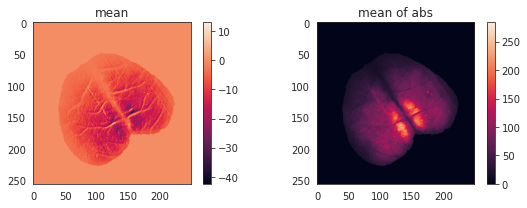

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


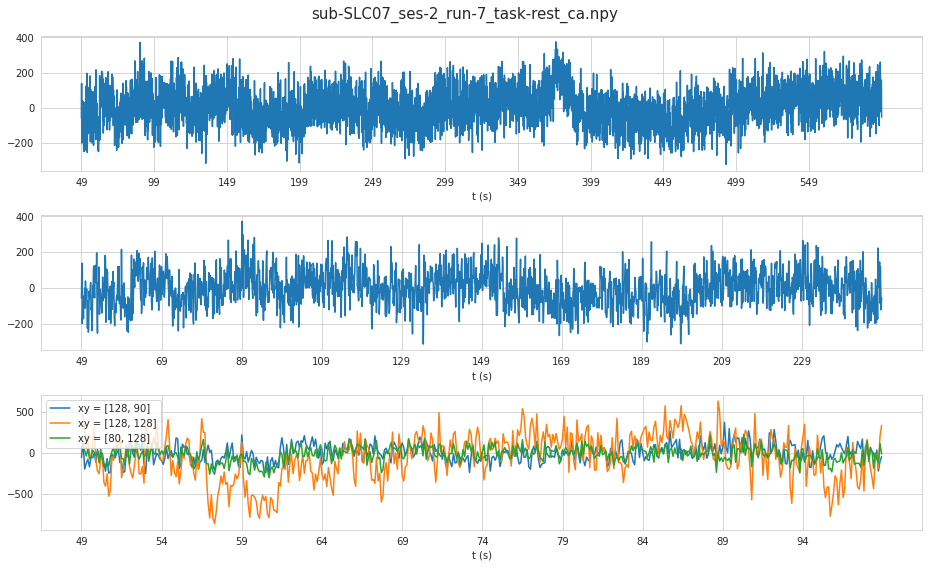

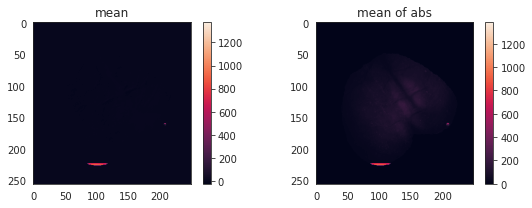

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


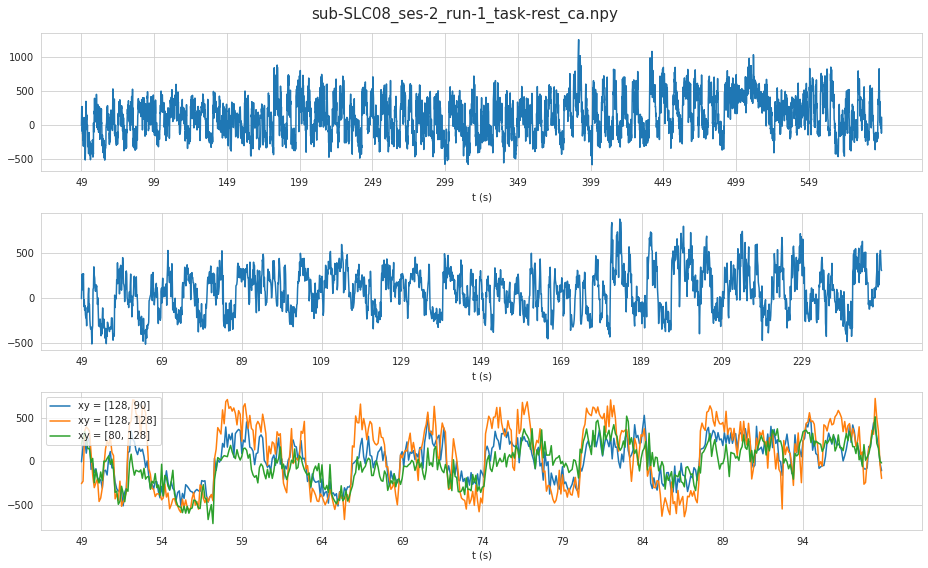

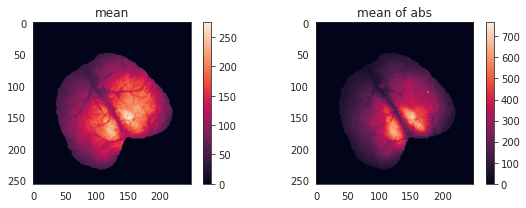

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


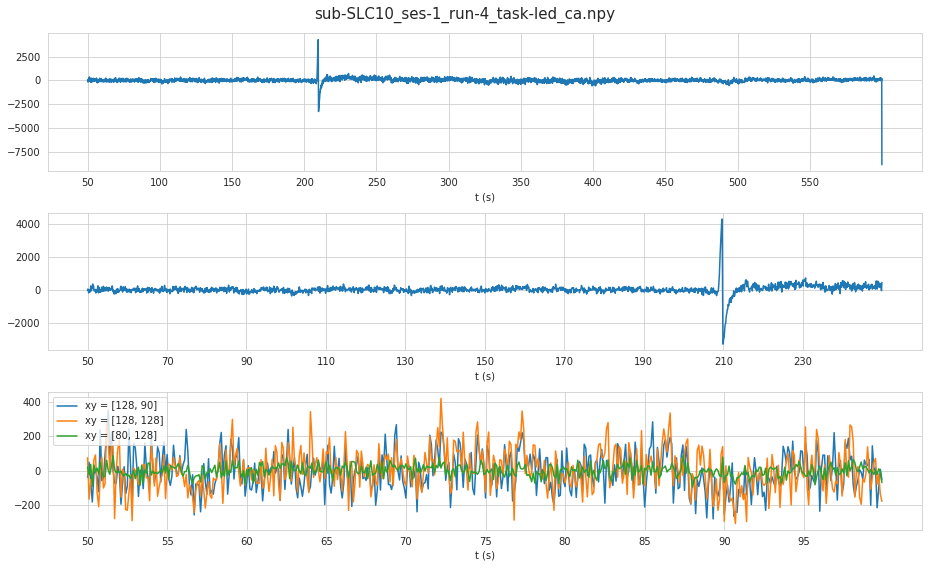

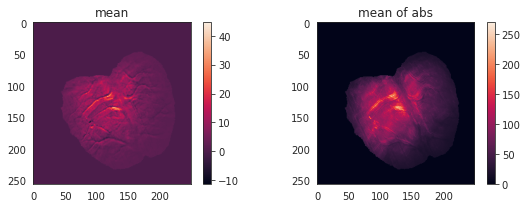

---------------------------------------------------------------------------------------------------- 






In [4]:
# HIDE CODE



nt = 600   # 600 seconds
ca_frequency = 10
exclude_seconds = 50


for load_filename in sorted(filter(lambda x: 'ca' in x, os.listdir(processed_dir))):
    ca = np.load(pjoin(processed_dir, load_filename), mmap_mode='r')
    
    start = ca.shape[-1] - ((nt - exclude_seconds) * ca_frequency)
    end = ca.shape[-1]
    
    # print("file name:  {:s}\tshape:  {}\ttrange included:  {}"
     #     .format(load_filename, ca.shape, [start, end]))
    trange = range(start, end)
    ca = ca[..., 0, trange]

    print('-' * 100)
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(13, 8))
    
    plt.subplot(311)
    intvl = range(0, end - start)
    xticks = [item for item in intvl if item % (len(intvl) // 11) == 0]
    xtick_labels = [(item + start) // ca_frequency for item in xticks]
    plt.plot(ca[128, 90, intvl])
    plt.xticks(xticks, xtick_labels)
    plt.xlabel('t (s)')
    
    plt.subplot(312)
    intvl = range(0, 2000)
    xticks = [item for item in intvl if item % (len(intvl) // 10) == 0]
    xtick_labels = [(item + start) // ca_frequency for item in xticks]
    plt.plot(ca[128, 90, intvl])
    plt.xticks(xticks, xtick_labels)
    plt.xlabel('t (s)')
    
    plt.subplot(313)
    intvl = range(0, 500)
    xticks = [item for item in intvl if item % (len(intvl) // 10) == 0]
    xtick_labels = [(item + start) // ca_frequency for item in xticks]
    plt.plot(ca[128, 90, intvl], label='xy = [128, 90]')
    plt.plot(ca[128, 128, intvl], label='xy = [128, 128]')
    plt.plot(ca[80, 128, intvl], label='xy = [80, 128]')
    plt.xticks(xticks, xtick_labels)
    plt.xlabel('t (s)')
    plt.legend(loc='upper left')
    
    plt.suptitle(load_filename, fontsize=15)
    plt.tight_layout()
    plt.show()
    
    
    sns.set_style('white')
    plt.figure(figsize=(8, 3))

    plt.subplot(121)
    plt.imshow(ca.mean(-1))
    plt.colorbar()
    plt.title('mean')

    plt.subplot(122)
    plt.imshow(np.abs(ca).mean(-1))
    plt.colorbar()
    plt.title('mean of abs')

    plt.tight_layout()
    plt.show()
    
    print('-' * 100, '\n\n\n\n')

## Simple analysis

I choose a dataset that looks OK from subject named **sub-SLC08**.

In [6]:
# HIDE CODE


load_filename = next(filter(lambda x: 'ca' in x and 'sub-SLC08' in x, os.listdir(processed_dir)))
ca = np.load(pjoin(processed_dir, load_filename), mmap_mode='r')

exclude_seconds = 0
start = ca.shape[-1] - ((nt - exclude_seconds) * ca_frequency)
end = start + 2090 # ca.shape[-1]

trange = range(start, end)
ca = ca[..., 0, trange]

### Correlation analysis

Take a source signal from one of the "voxels" and compute its correlation with every other point. We should not call these voxels because this is different than fMRI data.  But then if not voxels, what should we call them for Ca data?

Anyway, I take signal from point (128, 128) on cortex surface and compute its correlation with every other point.  Here is how this correlation result looks like.

/home/hadi/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


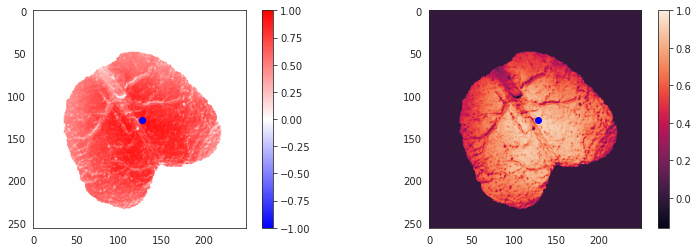

In [7]:
# HIDE CODE


source = (128, 128)
corrs = np.zeros(ca.shape[:-1])

for i in tqdm(range(ca.shape[0]), leave=False):
    for j in range(ca.shape[1]):
        r, p = pearsonr(ca[i, j, :], ca[source[0], source[1], :])
        if not np.isnan(r):
            corrs[i, j] = r
        
plt.figure(figsize=(13, 4))

plt.subplot(121)
plt.imshow(corrs, vmin=-1, vmax=1, cmap='bwr')
plt.plot(source[0], source[1], color='b', marker='o')
plt.colorbar()

plt.subplot(122)
plt.imshow(corrs)
plt.plot(source[0], source[1], color='b', marker='o')
plt.colorbar()
plt.show()

Everything is correlated with everything else. Possibly because wide-filed Ca imaging data is actually caused by neuro-pill (i.e. large aggregated activity due to axons).  It might be correlated with LFP if we could measure it.  So maybe these are slow long wavelength oscillations just like LFP in anesthetized state.

Below is another plot from two neighboring points.

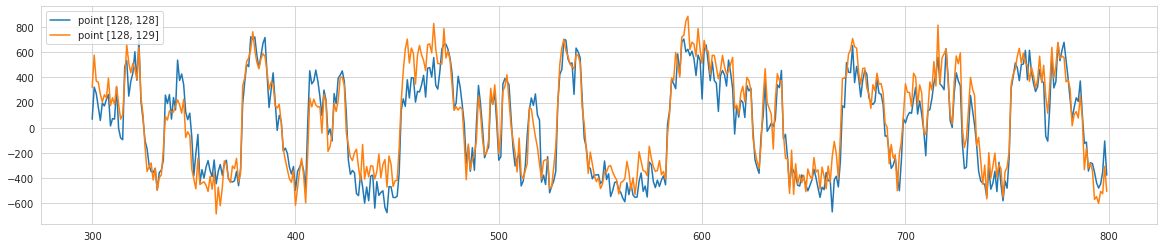

In [8]:
# HIDE CODE


intvl = range(300, 800)
sns.set_style('whitegrid')
plt.figure(figsize=(20, 4))
plt.plot(intvl, ca[128, 128][intvl], label='point [128, 128]')
plt.plot(intvl, ca[128, 129][intvl], label='point [128, 129]')
plt.legend()
plt.show()

### Non-negative matrix factorization (NMF)

Ca imaging data is a signal that always has non-negative values by definition.  A natural method that fits this is NMF, where a positive matrix is factorized into two positive matrices:  $X = WF$, where $F$ are factors, and $W$ are loading matrices.

We first compute the absolute value of Ca traces to meet the non-negative criterion.  After this step, above traces look like this:

In [42]:
# HIDE CODE



def smoothen(arr: np.ndarray, filter_sz: int = 5):
    shape = arr.shape
    assert 1 <= len(shape) <= 2, "1 <= dim <= 2d"

    kernel = np.ones(filter_sz) / filter_sz
    if len(shape) == 1:
        return np.convolve(arr, kernel, mode='same')
    else:
        smoothed = np.zeros(arr.shape)
        for i in range(arr.shape[0]):
            smoothed[i] = np.convolve(arr[i], kernel, mode='same')
        return smoothed

X = ca.copy().reshape(-1, ca.shape[-1])
X += np.mean(np.abs(X[X<0]))
X = smoothen(X.T, filter_sz=5)
X = np.maximum(0.0, X)
X /= X.std()

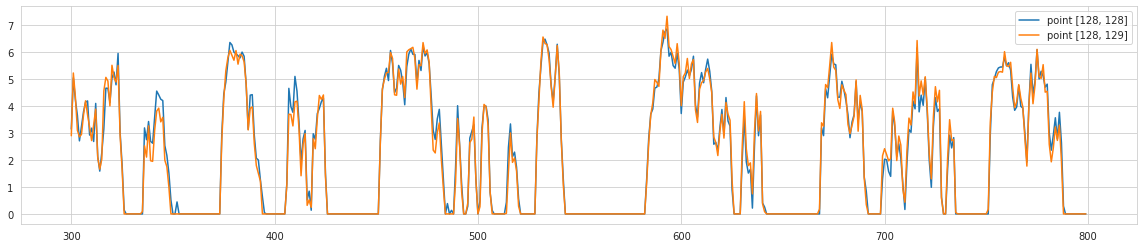

In [43]:
# HIDE CODE


intvl = range(300, 800)
sns.set_style('whitegrid')
plt.figure(figsize=(20, 4))
plt.plot(intvl, X.T.reshape(*ca.shape)[128, 128][intvl], label='point [128, 128]')
plt.plot(intvl, X.T.reshape(*ca.shape)[128, 129][intvl], label='point [128, 129]')
plt.legend()
plt.show()

In [52]:
# HIDE CODE


from sklearn.decomposition import NMF

model = NMF(
    n_components=16,
    init='nndsvd',
    max_iter=1500,
    random_state=42,
)
W = model.fit_transform(X)

/home/hadi/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [53]:
model.reconstruction_err_

2842.055692536043

Here is how the factors look like:

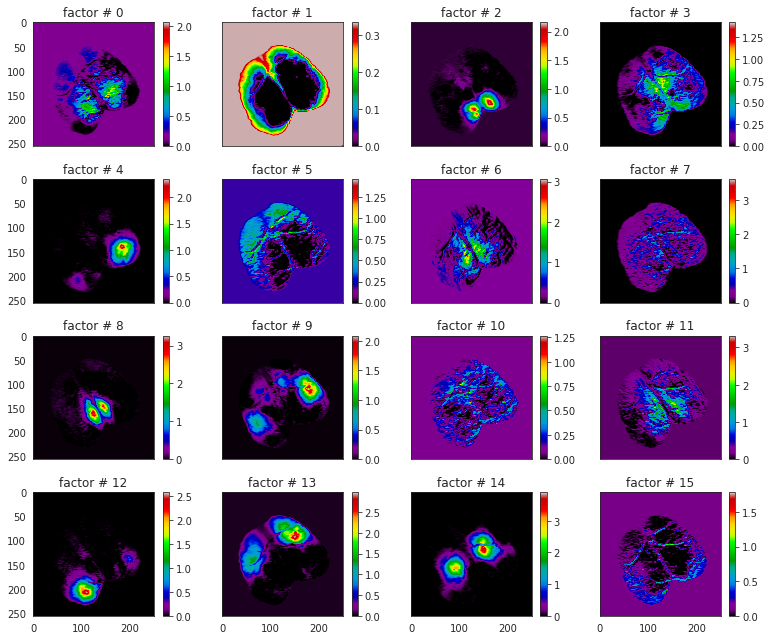

In [56]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 9), sharex='all', sharey='all')

for c in range(model.n_components_):
    i, j = c // ncols, c % ncols
    comp = model.components_[c].reshape(ca.shape[:2])
    im = axes[i, j].imshow(comp, cmap='nipy_spectral')#'' 'gist_ncar')
    axes[i, j].set_title('factor # {:d}'.format(c))
    plt.colorbar(im, ax=axes[i, j])
    
fig.tight_layout()
plt.show()

These factors almost achieve an unsupervised parcellation.  Let's look at 4 of them in a bit larger plot

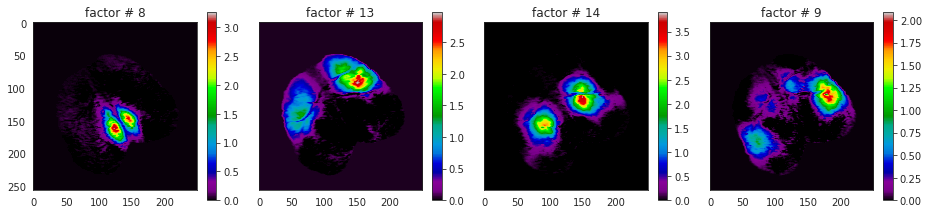

In [63]:
# HIDE CODE


selected_factors = [8, 13, 14, 9]

sns.set_style('white')
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 3), sharex='all', sharey='all')
if len(axes.shape) != 2:
    axes = axes.reshape(nrows, ncols)

for idx, c in enumerate(selected_factors):
    i, j = idx // ncols, idx % ncols
    comp = model.components_[c].reshape(ca.shape[:2])
    im = axes[i, j].imshow(comp, cmap='nipy_spectral')#'' 'gist_ncar')
    axes[i, j].set_title('factor # {:d}'.format(c))
    plt.colorbar(im, ax=axes[i, j])
    
fig.tight_layout()
plt.show()

In [86]:
# HIDE CODE


palette = sns.color_palette("Accent_r", n_colors=model.n_components_)
palette

[(0.4, 0.4, 0.4),
 (0.4, 0.4, 0.4),
 (0.7490196078431373, 0.3568627450980392, 0.09019607843137253),
 (0.7490196078431373, 0.3568627450980392, 0.09019607843137253),
 (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 (0.2196078431372549, 0.4235294117647059, 0.6901960784313725),
 (0.2196078431372549, 0.4235294117647059, 0.6901960784313725),
 (1.0, 1.0, 0.6),
 (1.0, 1.0, 0.6),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.4980392156862745, 0.788235294117647, 0.4980392156862745),
 (0.4980392156862745, 0.788235294117647, 0.4980392156862745)]

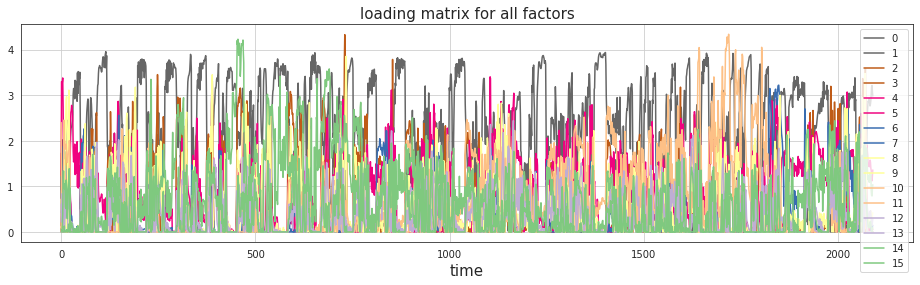

In [98]:
# HIDE CODE


plt.figure(figsize=(16, 4))
sns.lineplot(data=W, legend='full', palette=palette, dashes=False)
plt.title('loading matrix for all factors', fontsize=15)
plt.xlabel('time', fontsize=15)
plt.grid()
plt.show()

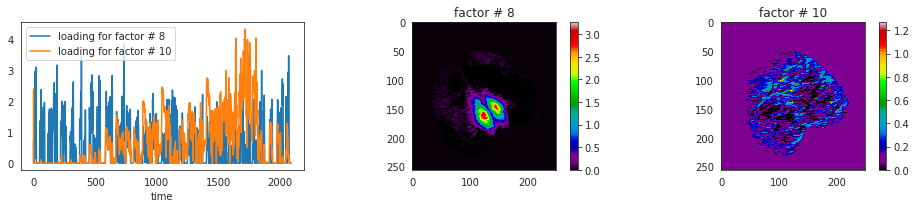

In [99]:
plt.figure(figsize=(13, 3))

plt.subplot(131)
plt.plot(W[:, 8], label='loading for factor # 8')
plt.plot(W[:, 10], label='loading for factor # 10')
plt.xlabel('time', fontsize=10)
plt.legend()

plt.subplot(132)
c = 8
comp = model.components_[c].reshape(ca.shape[:2])
plt.imshow(comp, cmap='nipy_spectral')#'' 'gist_ncar')
plt.title('factor # {:d}'.format(c))
plt.colorbar()

plt.subplot(133)
c = 10
comp = model.components_[c].reshape(ca.shape[:2])
plt.imshow(comp, cmap='nipy_spectral')#'' 'gist_ncar')
plt.title('factor # {:d}'.format(c))
plt.colorbar()

plt.tight_layout()
plt.show()

Factor # 8 is more or less present throughout, but # 10 kicks in towards seconf half.

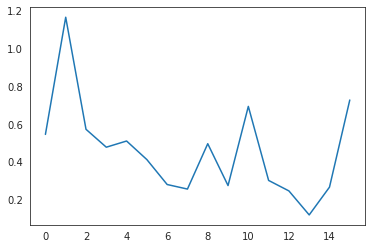

In [100]:
plt.plot(W.var(0))

In [101]:
np.argsort(W.var(0))

array([13, 12,  7, 14,  9,  6, 11,  5,  3,  8,  4,  0,  2, 10, 15,  1])

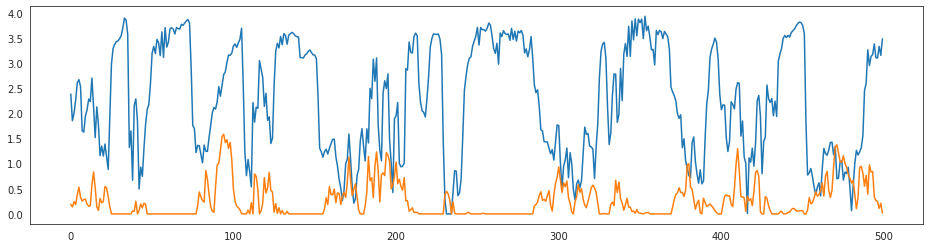

In [103]:
intvl = range(300, 800)
plt.figure(figsize=(16, 4))
plt.plot(W[intvl][:, [1, 13]])

<AxesSubplot:>

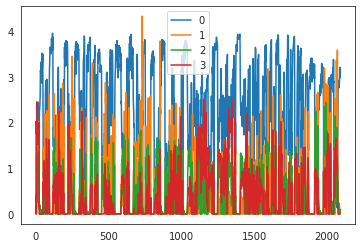

In [105]:
sns.lineplot(data=W[:, [1, 2, 14, 11]], legend='full', dashes=False)

In [106]:
X_pred = model.inverse_transform(W)
X_pred.shape

(2090, 64000)

In [111]:
indxs = np.argsort(W[:, 8] - W[:, 10])

indxs[:10], indxs[-10:]

(array([1717, 1716, 1643, 1714, 1712, 1718, 1720, 1803, 1711, 1641]),
 array([ 473,   13,   14,  388,  734,   20,  191,  733, 2069,  389]))

In [114]:
plot_indxs = [389, 2069, 733, 1717, 1643, 1803]
#[1640, 1714, 1719, 170, 191, 169]
# [813, 508, 106, 373, 727, 399]
# plot_indxs = [x + 99 for x in plot_indxs]
# good stuff: [203, 386, 195, 67, 418, 1609]

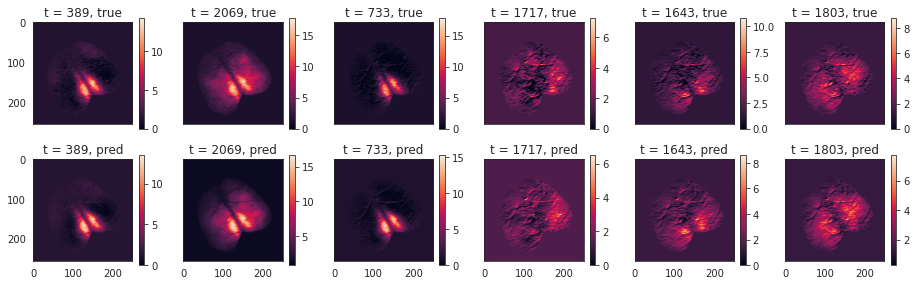

In [115]:
nrows, ncols = 2, len(plot_indxs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 4), sharex='all', sharey='all')

vmax = np.max(X[plot_indxs])
vmin = np.min(X[plot_indxs])

for c in range(ncols):
    t = plot_indxs[c]
    
    im = axes[0, c].imshow(X[t].reshape(*ca.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[0, c].set_title('t = {:d}, true'.format(t))
    plt.colorbar(im, ax=axes[0, c])
    
    im = axes[1, c].imshow(X_pred[t].reshape(*ca.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[1, c].set_title('t = {:d}, pred'.format(t))
    plt.colorbar(im, ax=axes[1, c])
    
fig.tight_layout()
plt.show()

In [118]:
indxs = np.argsort(W[:, 12] - W[:, 4])

indxs[:10], indxs[-10:]

(array([1828, 1829, 1830, 1843, 2069, 1842, 2025, 2070, 1827,  349]),
 array([ 631, 1531,  249, 1150,  940,  630,   93,   91,  629,   92]))

In [121]:
plot_indxs = [92, 629, 940, 1828, 2025, 349]
# [813, 508, 106, 373, 727, 399]
# plot_indxs = [x + 99 for x in plot_indxs]
# good stuff: [203, 386, 195, 67, 418, 1609]

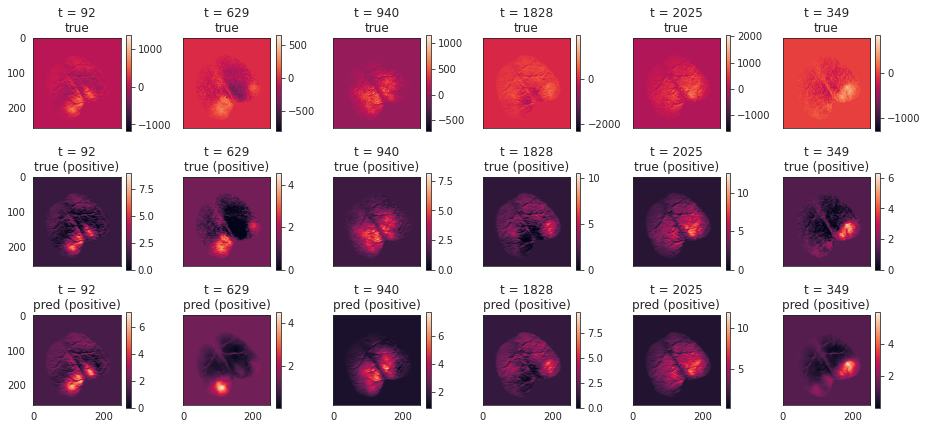

In [122]:
nrows, ncols = 3, len(plot_indxs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 6), sharex='all', sharey='all')

vmax = np.max(X[plot_indxs])
vmin = np.min(X[plot_indxs])

for c in range(ncols):
    t = plot_indxs[c]
    
    im = axes[0, c].imshow(ca[..., t])#, vmin=vmin, vmax=vmax)
    axes[0, c].set_title('t = {:d}\ntrue'.format(t))
    plt.colorbar(im, ax=axes[0, c])
    
    im = axes[1, c].imshow(X[t].reshape(*ca.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[1, c].set_title('t = {:d}\ntrue (positive)'.format(t))
    plt.colorbar(im, ax=axes[1, c])
    
    im = axes[2, c].imshow(X_pred[t].reshape(*ca.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[2, c].set_title('t = {:d}\npred (positive)'.format(t))
    plt.colorbar(im, ax=axes[2, c])
    
fig.tight_layout()
plt.show()

### ICA

In [123]:
X = ca.copy().reshape(-1, ca.shape[-1])
X += np.mean(np.abs(X[X<0]))
X = smoothen(X.T, filter_sz=5)
# X = np.maximum(0.0, X)
X /= X.std()

In [124]:
from sklearn.decomposition import FastICA
ica = FastICA(
    n_components=16,
    random_state=42,
)
X_ica = ica.fit_transform(X)
X_ica.shape

(2090, 16)

In [125]:
ica.components_.shape

(16, 64000)

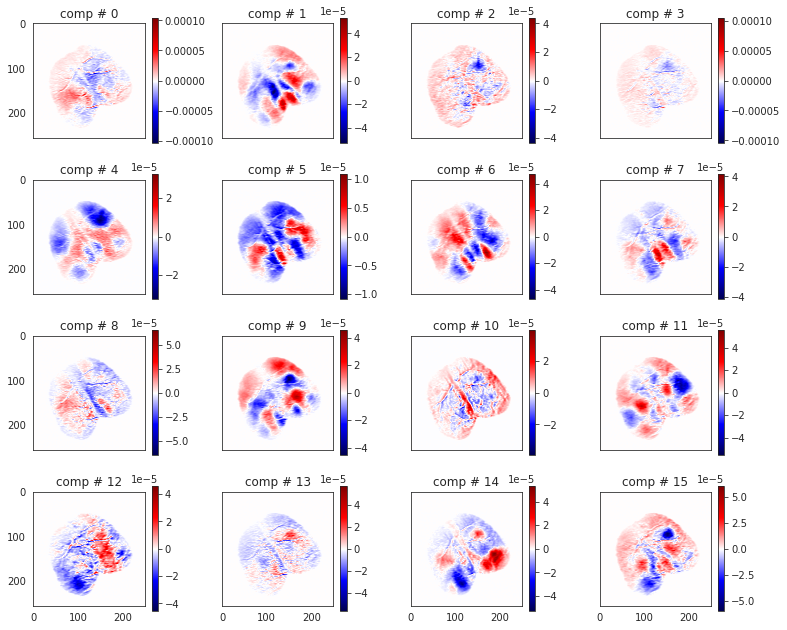

In [127]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 9), sharex='all', sharey='all')

for c in range(model.n_components_):
    i, j = c // ncols, c % ncols
    comp = ica.components_[c].reshape(ca.shape[:2])
    vmax = np.max(np.abs(comp))
    im = axes[i, j].imshow(comp, cmap='seismic', vmin=-vmax, vmax=vmax)#'' 'gist_ncar')
    axes[i, j].set_title('comp # {:d}'.format(c))
    plt.colorbar(im, ax=axes[i, j])
    
fig.tight_layout()
plt.show()

In [128]:
X_ica.shape

(2090, 16)

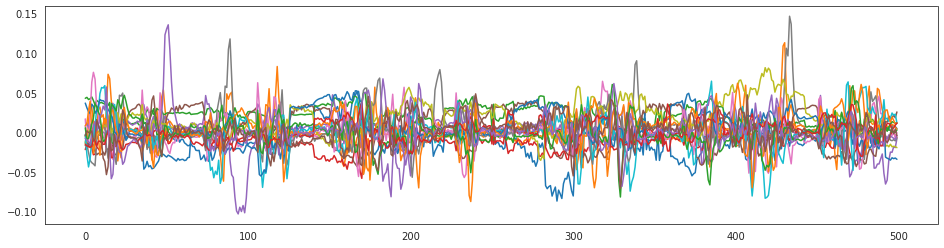

In [129]:
intvl = range(300, 800)

plt.figure(figsize=(16, 4))
plt.plot(X_ica[intvl]);

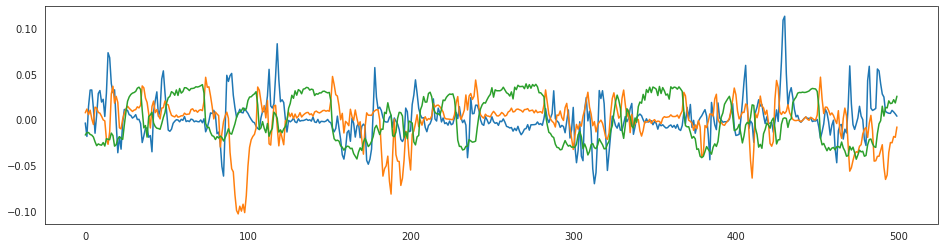

In [131]:
intvl = range(300, 800)
plt.figure(figsize=(16, 4))
plt.plot(X_ica[intvl][:, [1, 4, 5]])

In [132]:
X_pred = ica.inverse_transform(X_ica)
X_pred.shape

(2090, 64000)

In [133]:
X.shape

(2090, 64000)

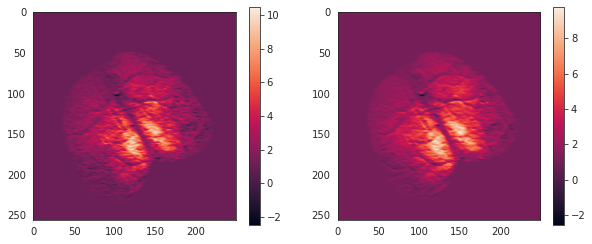

In [135]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(X[10].reshape(*ca.shape[:2]))
plt.colorbar()

plt.subplot(122)
plt.imshow(X_pred[10].reshape(*ca.shape[:2]))
plt.colorbar()

In [137]:
indxs = np.argsort(X_ica[:, 9] - X_ica[:, 5])

indxs[:10], indxs[-10:]

(array([ 127,  710, 1586, 1938, 1367, 1988,  719,  635,  711,  720]),
 array([777, 467, 684, 312, 778, 779, 780, 768, 685, 769]))

In [139]:
plot_indxs = [769, 685, 312, 127,  710, 1586]

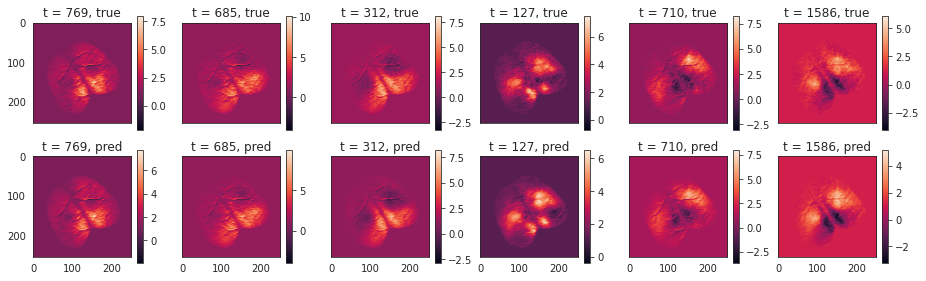

In [143]:
nrows, ncols = 2, len(plot_indxs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 4), sharex='all', sharey='all')

vmax = np.max(X[plot_indxs])
vmin = np.min(X[plot_indxs])

for c in range(ncols):
    t = plot_indxs[c]
    
    im = axes[0, c].imshow(X[t].reshape(*ca.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[0, c].set_title('t = {:d}, true'.format(t))
    plt.colorbar(im, ax=axes[0, c])
    
    im = axes[1, c].imshow(X_pred[t].reshape(*ca.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[1, c].set_title('t = {:d}, pred'.format(t))
    plt.colorbar(im, ax=axes[1, c])
    
fig.tight_layout()
plt.show()

### PCA

In [144]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=16,
    svd_solver='full',
)
X_pca = pca.fit_transform(X)
X_pca.shape

(2090, 16)

In [145]:
pca.components_.shape, pca.explained_variance_ratio_ * 100

((16, 64000),
 array([76.9038783 ,  5.98941059,  5.07878186,  1.700163  ,  1.33925885,
         1.1219075 ,  0.92914458,  0.66161688,  0.49900535,  0.42497472,
         0.35813588,  0.28525064,  0.23714309,  0.17315645,  0.14409418,
         0.12349067]))

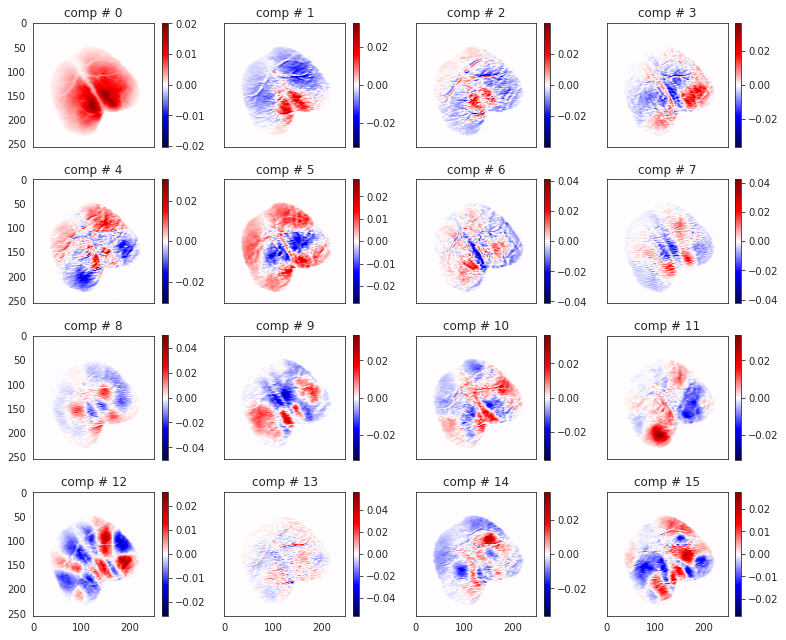

In [146]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 9), sharex='all', sharey='all')

for c in range(model.n_components_):
    i, j = c // ncols, c % ncols
    comp = pca.components_[c].reshape(ca.shape[:2])
    vmax = np.max(np.abs(comp))
    im = axes[i, j].imshow(comp, cmap='seismic', vmin=-vmax, vmax=vmax)
    axes[i, j].set_title('comp # {:d}'.format(c))
    plt.colorbar(im, ax=axes[i, j])
    
fig.tight_layout()
plt.show()

### This could mean either of two things:

1. Those regions were more active (retrosplenial?)
2. Or this is an artifact inherent to the data.  E.g. those parts of the cortex were not more active, but the light was more accessible to the microscope from those regions?

In [147]:
X_pca.shape

(2090, 16)

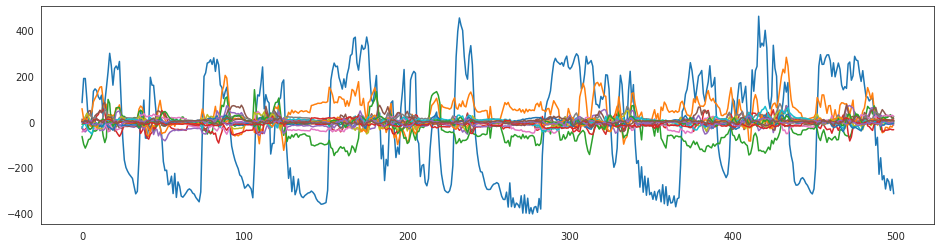

In [148]:
intvl = range(300, 800)

plt.figure(figsize=(16, 4))
plt.plot(X_pca[intvl]);

In [149]:
X_pca.var(0)

array([47948.86996121,  3734.34312908,  3166.57438558,  1060.03619747,
         835.01573465,   699.4991429 ,   579.31320893,   412.51211589,
         311.12530833,   264.96787749,   223.29447034,   177.85118159,
         147.85656096,   107.96147727,    89.8414109 ,    76.99531331])

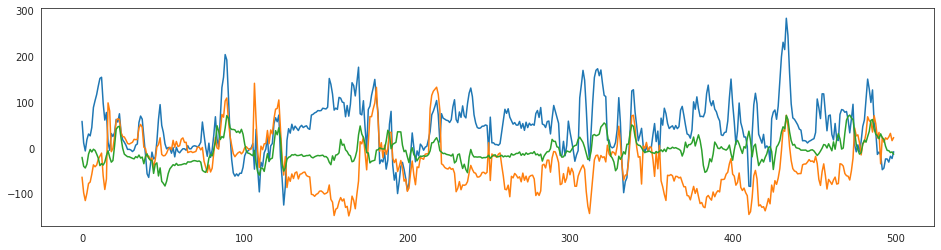

In [150]:
intvl = range(300, 800)
plt.figure(figsize=(16, 4))
plt.plot(X_pca[intvl][:, [1, 2, 4]])

In [151]:
X_pred = pca.inverse_transform(X_pca)
X_pred.shape

(2090, 64000)

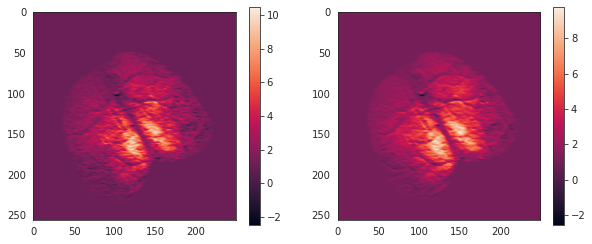

In [153]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(X[10].reshape(*ca.shape[:2]))
plt.colorbar()

plt.subplot(122)
plt.imshow(X_pred[10].reshape(*ca.shape[:2]))
plt.colorbar()

In [154]:
indxs = np.argsort(X_pca[:, 12] - X_pca[:, 0])

indxs[:10], indxs[-10:]

(array([2023, 2005, 2021, 2022, 1981, 1923, 2067, 1985, 1921, 1980]),
 array([1399,  582, 1661,  115, 1663,  571,  580,  573,  575,  577]))

In [160]:
plot_indxs = [68, 826, 417, 22, 116, 18]

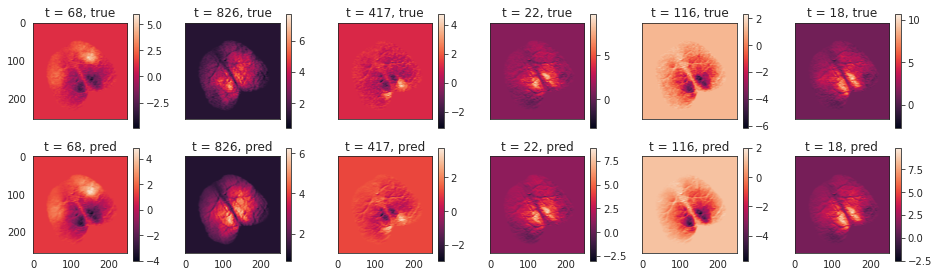

In [161]:
nrows, ncols = 2, len(plot_indxs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 4), sharex='all', sharey='all')

vmax = np.max(X[plot_indxs])
vmin = np.min(X[plot_indxs])

for c in range(ncols):
    t = plot_indxs[c]
    
    im = axes[0, c].imshow(X[t].reshape(*ca.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[0, c].set_title('t = {:d}, true'.format(t))
    plt.colorbar(im, ax=axes[0, c])
    
    im = axes[1, c].imshow(X_pred[t].reshape(*ca.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[1, c].set_title('t = {:d}, pred'.format(t))
    plt.colorbar(im, ax=axes[1, c])
    
fig.tight_layout()
plt.show()

In [162]:
from sklearn.metrics import r2_score

r2_score(X, X_pred) * 100

32.5488334792459

## Discussion

No discussion, waiting for their response